In [ ]:
# === STEP 0: Install All Required Packages ===

!pip install numpy pandas scikit-learn xgboost lightgbm imbalanced-learn matplotlib seaborn joblib arff
!pip install catboost --quiet

# Optional: suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

print("✅ All libraries installed successfully.")


  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4947 sha256=582e5ecc6b67b6be9203009e37f2f96e63491178ee01850285bbec3a46779d5c
  Stored in directory: /root/.cache/pip/wheels/a7/30/97/2e32fa29b02eafc957100656820b0b66f199057de8c77a1821
Successfully built arff
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
✅ All libraries installed successfully.


In [ ]:
# === STEP 1: Load and Explore Camel Dataset ===
import pandas as pd

# Path to your Camel dataset
camel_path = "/content/camel-1.6.csv"  # Update if the filename differs (camel-1.4, etc.)

# Load dataset
df_camel = pd.read_csv(camel_path)

print("=== Loaded Camel dataset ===")
print("Shape:", df_camel.shape)
print("Columns:", list(df_camel.columns))

# Try to find target column automatically
target_candidates = ['bug', 'defects', 'Defective', 'defective', 'label', 'class']
target_col = None
for c in df_camel.columns:
    if c.strip().lower() in target_candidates:
        target_col = c
        break

if target_col is None:
    raise ValueError("No target column found. Rename your target column to 'bug' or 'defects'.")

print("\nTarget column:", target_col)
print("\nLabel distribution:")
print(df_camel[target_col].value_counts())

# Check for missing values
print("\nMissing values:")
print(df_camel.isnull().sum().sum())

# Show basic statistics
print("\n=== Summary Statistics ===")
print(df_camel.describe().T.head(15))


=== Loaded Camel dataset ===
Shape: (965, 21)
Columns: ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']

Target column: bug

Label distribution:
bug
0    777
1    188
Name: count, dtype: int64

Missing values:
0

=== Summary Statistics ===
       count        mean         std  min        25%        50%         75%  \
wmc    965.0    8.573057   11.204905  0.0   3.000000   5.000000   10.000000   
dit    965.0    1.954404    1.273735  0.0   1.000000   1.000000    3.000000   
noc    965.0    0.525389    2.632117  0.0   0.000000   0.000000    0.000000   
cbo    965.0   11.102591   22.526859  0.0   4.000000   7.000000   12.000000   
rfc    965.0   21.422798   25.009324  0.0   6.000000  14.000000   27.000000   
lcom   965.0   79.331606  523.754729  0.0   0.000000   4.000000   28.000000   
ca     965.0    5.271503   21.691893  0.0   1.000000   2.000000    4.000000   
ce     965.0    6.42901

In [ ]:
# === STEP 2: Feature Selection & SMOTE Balancing ===
import numpy as np
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df_camel.drop(columns=[target_col])
y = df_camel[target_col].astype(int)

print(f"Original shape: {X.shape}, Class distribution: {np.bincount(y)}")

# --- 1. Remove low variance features ---
var_thresh = VarianceThreshold(threshold=0.0)
X_var = var_thresh.fit_transform(X)
X = X.loc[:, var_thresh.get_support()]
print(f"After variance threshold: {X.shape}")

# --- 2. Remove highly correlated features ---
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X = X.drop(columns=to_drop)
print(f"Dropping highly correlated features: {to_drop}")
print(f"After correlation filter: {X.shape}")

# --- 3. Mutual Information Ranking ---
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features by mutual information:\n", mi_series.head(10))

# --- 4. Recursive Feature Elimination (RFE) ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X, y)
selected_features = list(X.columns[rfe.support_])
print("\nSelected features via RFE:", selected_features)

X_sel = X[selected_features]

# --- 5. Apply SMOTE for class balancing ---
print("\nBefore SMOTE class distribution:", np.bincount(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_sel, y)
print("After SMOTE class distribution:", np.bincount(y_res))
print("Resampled shape:", X_res.shape)

print("\n=== Step 2 Completed ===")


Original shape: (965, 20), Class distribution: [777 188]
After variance threshold: (965, 20)
Dropping highly correlated features: ['ca', 'npm', 'loc', 'dam']
After correlation filter: (965, 16)

Top 10 features by mutual information:
 rfc       0.035755
amc       0.034605
avg_cc    0.028847
cbo       0.027131
lcom      0.021456
wmc       0.018366
cam       0.016447
dit       0.011944
ic        0.010063
mfa       0.009823
dtype: float64

Selected features via RFE: ['wmc', 'cbo', 'rfc', 'lcom', 'ce', 'lcom3', 'mfa', 'cam', 'amc', 'avg_cc']

Before SMOTE class distribution: [777 188]
After SMOTE class distribution: [777 777]
Resampled shape: (1554, 10)

=== Step 2 Completed ===


In [ ]:
# === STEP 3: Ensemble Model Training & Evaluation ===
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score, log_loss, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42, stratify=y_res)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

results = []

# --- RandomForest ---
rf_params = {'n_estimators': [100, 200], 'min_samples_split': [2, 5], 'max_depth': [None, 10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf.fit(X_train, y_train)
rf_best = rf.best_estimator_
print(f"RF best: {rf.best_params_} CV AUC: {rf.best_score_}")

# --- ExtraTrees ---
et_params = {'n_estimators': [100, 200], 'min_samples_split': [2, 5], 'max_depth': [None, 10, 20]}
et = GridSearchCV(ExtraTreesClassifier(random_state=42), et_params, cv=3, scoring='roc_auc', n_jobs=-1)
et.fit(X_train, y_train)
et_best = et.best_estimator_
print(f"ET best: {et.best_params_} CV AUC: {et.best_score_}")

# --- XGBoost ---
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train, y_train)
print("XGB done")

# --- LightGBM ---
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
print("LGB done")

# --- Stacking Ensemble ---
stack = StackingClassifier(
    estimators=[('rf', rf_best), ('et', et_best), ('xgb', xgb), ('lgb', lgb)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    passthrough=True,
    n_jobs=-1
)
stack.fit(X_train, y_train)
print("Stacking trained")

# --- Evaluation Helper ---
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    print(f"\n--- {name} ---")
    print(f"AUC: {auc:.4f}  F1: {f1:.4f}  Precision: {precision:.4f}  Recall: {recall:.4f}  MCC: {mcc:.4f}  Acc: {acc:.4f}  LogLoss: {ll:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))
    results.append([name, auc, f1, precision, recall, mcc, acc, ll])

# Evaluate all models
for name, model in [
    ("RandomForest_Tuned", rf_best),
    ("ExtraTrees_Tuned", et_best),
    ("XGBoost", xgb),
    ("LightGBM", lgb),
    ("Stacking_Ensemble", stack)
]:
    evaluate_model(name, model, X_test, y_test)

# Summarize results
results_df = pd.DataFrame(results, columns=["Model", "AUC", "F1", "Precision", "Recall", "MCC", "Accuracy", "LogLoss"])
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
print("\n=== Model Performance Summary ===")
display(results_df)


Train shape: (1320, 10), Test shape: (234, 10)
RF best: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.9171694214876033
ET best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.936456611570248
XGB done
[LightGBM] [Info] Number of positive: 660, number of negative: 660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1732
[LightGBM] [Info] Number of data points in the train set: 1320, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGB done
Stacking trained

--- RandomForest_Tuned ---
AUC: 0.9279  F1: 0.8898  Precision: 0.8824  Recall: 0.8974  MCC: 0.7779  Acc: 0.8889  LogLoss: 0.3717
Confusion matrix:
 [[103  14]
 [ 12 105]]
Classification report:
               precision  

,Model,AUC,F1,Precision,Recall,MCC,Accuracy,LogLoss
0,ExtraTrees_Tuned,0.935970,0.888889,0.888889,0.888889,0.777778,0.888889,0.339540
1,RandomForest_Tuned,0.927862,0.889831,0.882353,0.897436,0.777891,0.888889,0.371684
2,Stacking_Ensemble,0.927679,0.826667,0.861111,0.794872,0.668648,0.833333,0.472327
3,LightGBM,0.922712,0.864407,0.857143,0.871795,0.726602,0.863248,0.354974
4,XGBoost,0.918402,0.832618,0.836207,0.829060,0.666691,0.833333,0.384077


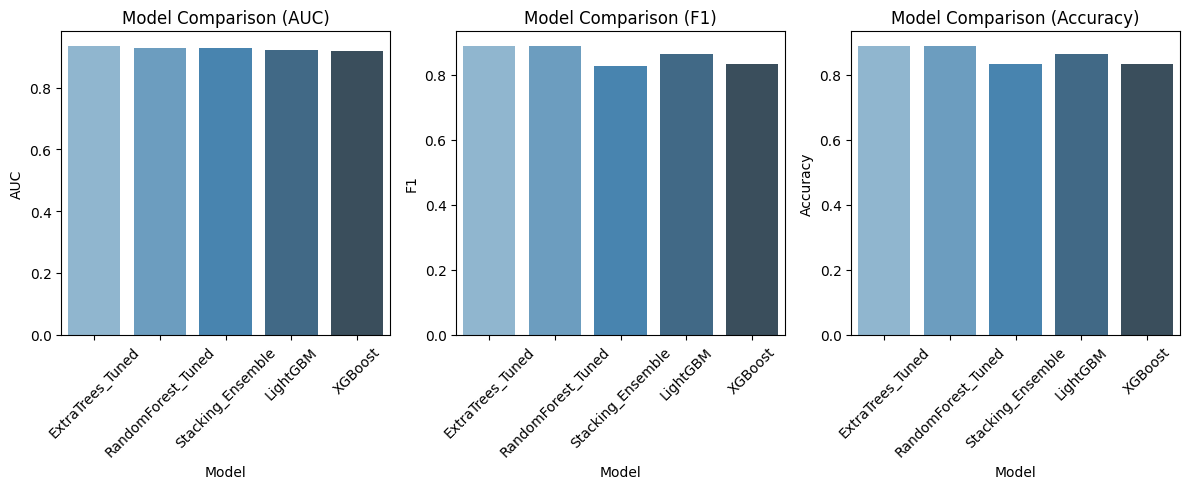

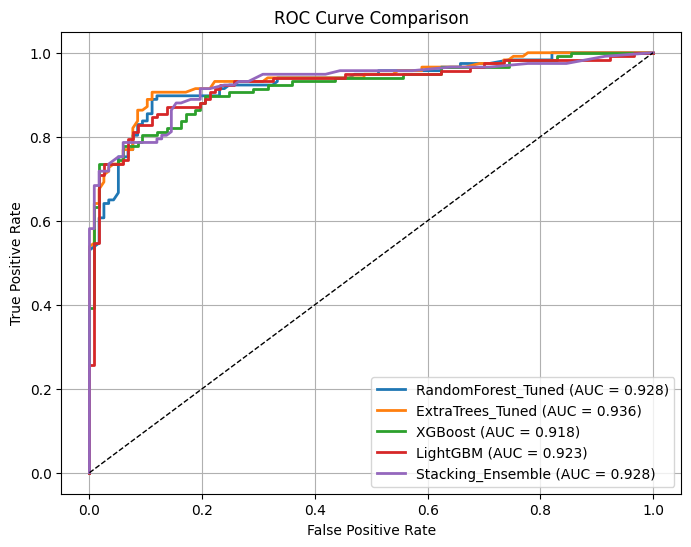

In [ ]:
# === STEP 4: Visual Model Comparison (Bar Plots + ROC Curves) ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# --- Bar Plot: Comparison of AUC, F1, Accuracy ---
metrics = ["AUC", "F1", "Accuracy"]
plt.figure(figsize=(12, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x="Model", y=metric, data=results_df, palette="Blues_d")
    plt.xticks(rotation=45)
    plt.title(f"Model Comparison ({metric})")
plt.tight_layout()
plt.show()

# --- ROC Curves for All Models ---
plt.figure(figsize=(8, 6))
for name, model in [
    ("RandomForest_Tuned", rf_best),
    ("ExtraTrees_Tuned", et_best),
    ("XGBoost", xgb),
    ("LightGBM", lgb),
    ("Stacking_Ensemble", stack)
]:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
